# Read data

In [1]:
import pandas as pd
import pickle

# read the dataframe from the pickle file
with open('norm_signals.pkl', 'rb') as f:
    norm_signals = pickle.load(f)
    
# read the dataframe from the pickle file
with open('datas.pkl', 'rb') as f:
    datas = pickle.load(f)

## Transform data

In [2]:
resp_df = datas["puzzler"]
norm_signals["puzzler"] = resp_df
norm_signals.head(5)

,participant,Round,Phase,TEMP,HR,BVP,EDA,puzzler
0,D1_0_id1,1,1,"[0.05473091971809032, 0.05479950720180299, 0.0...","[0.054003470728475264, 0.05399018375046446, 0....","[0.11626114289428856, -0.14552122914282697, 0....","[0.0016481043520853906, 0.001553720510941719, ...",1
1,D1_0_id1,1,2,"[0.05702831060067079, 0.0570437953071332, 0.05...","[0.06969438144176515, 0.06962799202112016, 0.0...","[-0.08987183069122301, 0.08053956964211931, -0...","[0.003159325253012549, 0.0030586312420729507, ...",1
2,D1_0_id1,1,3,"[0.058256531110973446, 0.05822778981939402, 0....","[0.05940029965990726, 0.05938568484969654, 0.0...","[0.021714462512408668, -0.014463379499449676, ...","[0.00363021312627999, 0.0035602702682669156, 0...",1
3,D1_0_id1,2,1,"[0.058972256732085046, 0.05891698065488913, 0....","[0.053707946849570254, 0.05382838906300378, 0....","[-0.030266065885235748, 0.029438081953216927, ...","[0.004227034116410407, 0.004154095436311112, 0...",1
4,D1_0_id1,2,2,"[0.0595598586308989, 0.05951781369096178, 0.05...","[0.05877407048794188, 0.05884402437428472, 0.0...","[0.04798942943624361, -0.006677150378347791, -...","[0.0034216910757086886, 0.0035055848649558977,...",1


In [3]:
# Get the unique participant
participant_id = norm_signals['participant'].unique()

# Initialize an empty dictionary to store DataFrames for each participant
participant_data = {}

# Loop through participant names
for  participant in participant_id:

        # Filter the data for the current participant and round   -   THIS IS WHERE WE DEFINE THE ROUND
        d = norm_signals[["participant", "TEMP", "HR", "BVP", "EDA", "Round", "Phase", "puzzler"]]
        d = d.loc[(norm_signals['participant'] == participant) & (norm_signals['Round'] == 4)]   # HERE WE CAN CHANGE THE ROUND

        # Extract the data for HR, TEMP, BVP, EDA into lists
        hr = list()
        temp = list()
        bvp = list()
        eda = list()
        puzzler = list()
        for i in range(len(d["Phase"])):
            temp.extend(d["TEMP"].iloc[i])
            hr.extend(d["HR"].iloc[i])
            bvp.extend(d["BVP"].iloc[i])
            eda.extend(d["EDA"].iloc[i])
            

        # Create a DataFrame for the current participant (270 = 3 x 270s of each Phase)
        participant_df = pd.DataFrame()
        participant_df["Time"] = [i for i in range(len(temp))]
        participant_df["TEMP"] = temp
        participant_df["HR"] = hr
        participant_df["BVP"] = bvp
        participant_df["EDA"] = eda
        
        
        # Construct the participant key for the dictionary
        participant_key = participant
        # Add the participant DataFrame to the dictionary
        participant_data[participant_key] = participant_df
        
# This is a dictionary containing the dataframe of each participant for 3 Phases (900s) for Round 1
# print(participant_data)


# PCA using eigenvalue analysis of the covariance matrix

In [4]:
import numpy as np
# Define the data matrix X by selecting the columns to be used for PCA
pca_results = dict()
# Loop through participant names
for participant in participant_id:
    # print(participant)
    # Access the participant DataFrame
    participant_df = participant_data[participant]

    # Drop the "Time(s)" column from the DataFrame
    participant_df = participant_df.drop("Time", axis=1)

    # print(participant_df)

    X = participant_df

    # Standardize the data
    # Xc = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Compute PCA as an eigenvalue analysis of the covariance matrix
    Eval, Evec = np.linalg.eig(np.cov(X.T))

    # Sort while still keeping the imaginary part, therefor lexicographic sorting
    # Also, descending sort
    sortIndex = np.argsort(Eval)[::-1] 

    Eval = Eval[sortIndex].astype(np.float64) # Away with imaginary part (~0) and order
    Evec = Evec[:, sortIndex].astype(np.float64)

    # Discard strictly none-positive eigenvalues modes
    Eval = Eval[np.where(Eval > 1e-9)]
    Evec = Evec[:, 0: len(Eval)]

    # Compute the transformed data
    Z = X @ Evec

    # Store the PCA results
    pca_results[participant] = {'Eval': Eval, 'Evec': Evec, 'Z': Z}
# pca_results

## Variance explained and loadings for each participant

In [5]:
# Loop through participant names
for participant in participant_id:
    pca = pca_results[participant]
    var_exp = (pca["Eval"] / np.sum(pca["Eval"])) * 100

    print('\n---------------------------------------------------------\n')
    
    print(f'Participant: \033[1m{participant}\033[0m')
    print("Variance explained by each component:", var_exp,"\n")
    
    
    print("Principal Component ", i+1, " Top Features:")
    top_features = np.argsort(np.abs(Evec[:,i]))[::-1][:5] # Get the indices of the top 5 features for this component
    
    loadings = pca_results[participant]['Evec']
    print(f'TEMP: {loadings[0][0]}')
    print(f'HR: {loadings[0][1]}')    
    print(f'BVP: {loadings[0][2]}')
    print(f'EDA: {loadings[0][3]}')


---------------------------------------------------------

Participant: D1_0_id1
Variance explained by each component: [9.79248848e+01 2.06560437e+00 6.54165113e-03 2.96919855e-03] 

Principal Component  3  Top Features:
TEMP: 4.484771956425257e-05
HR: 0.014937278486874546
BVP: -0.24135862337848996
EDA: 0.9703210245176324

---------------------------------------------------------

Participant: D1_0_id2
Variance explained by each component: [8.40428343e+01 1.59002562e+01 5.34695474e-02 3.43997123e-03] 

Principal Component  3  Top Features:
TEMP: 2.4228424907883583e-05
HR: -0.014966301827627468
BVP: 0.4856424776061407
EDA: 0.8740294006308686

---------------------------------------------------------

Participant: D1_0_id3
Variance explained by each component: [9.91033002e+01 7.01381405e-01 1.73815947e-01 2.15024188e-02] 

Principal Component  3  Top Features:
TEMP: 3.573756409057525e-05
HR: 0.004655162715089376
BVP: 0.12127286071028617
EDA: 0.9926082920457905

-------------------------

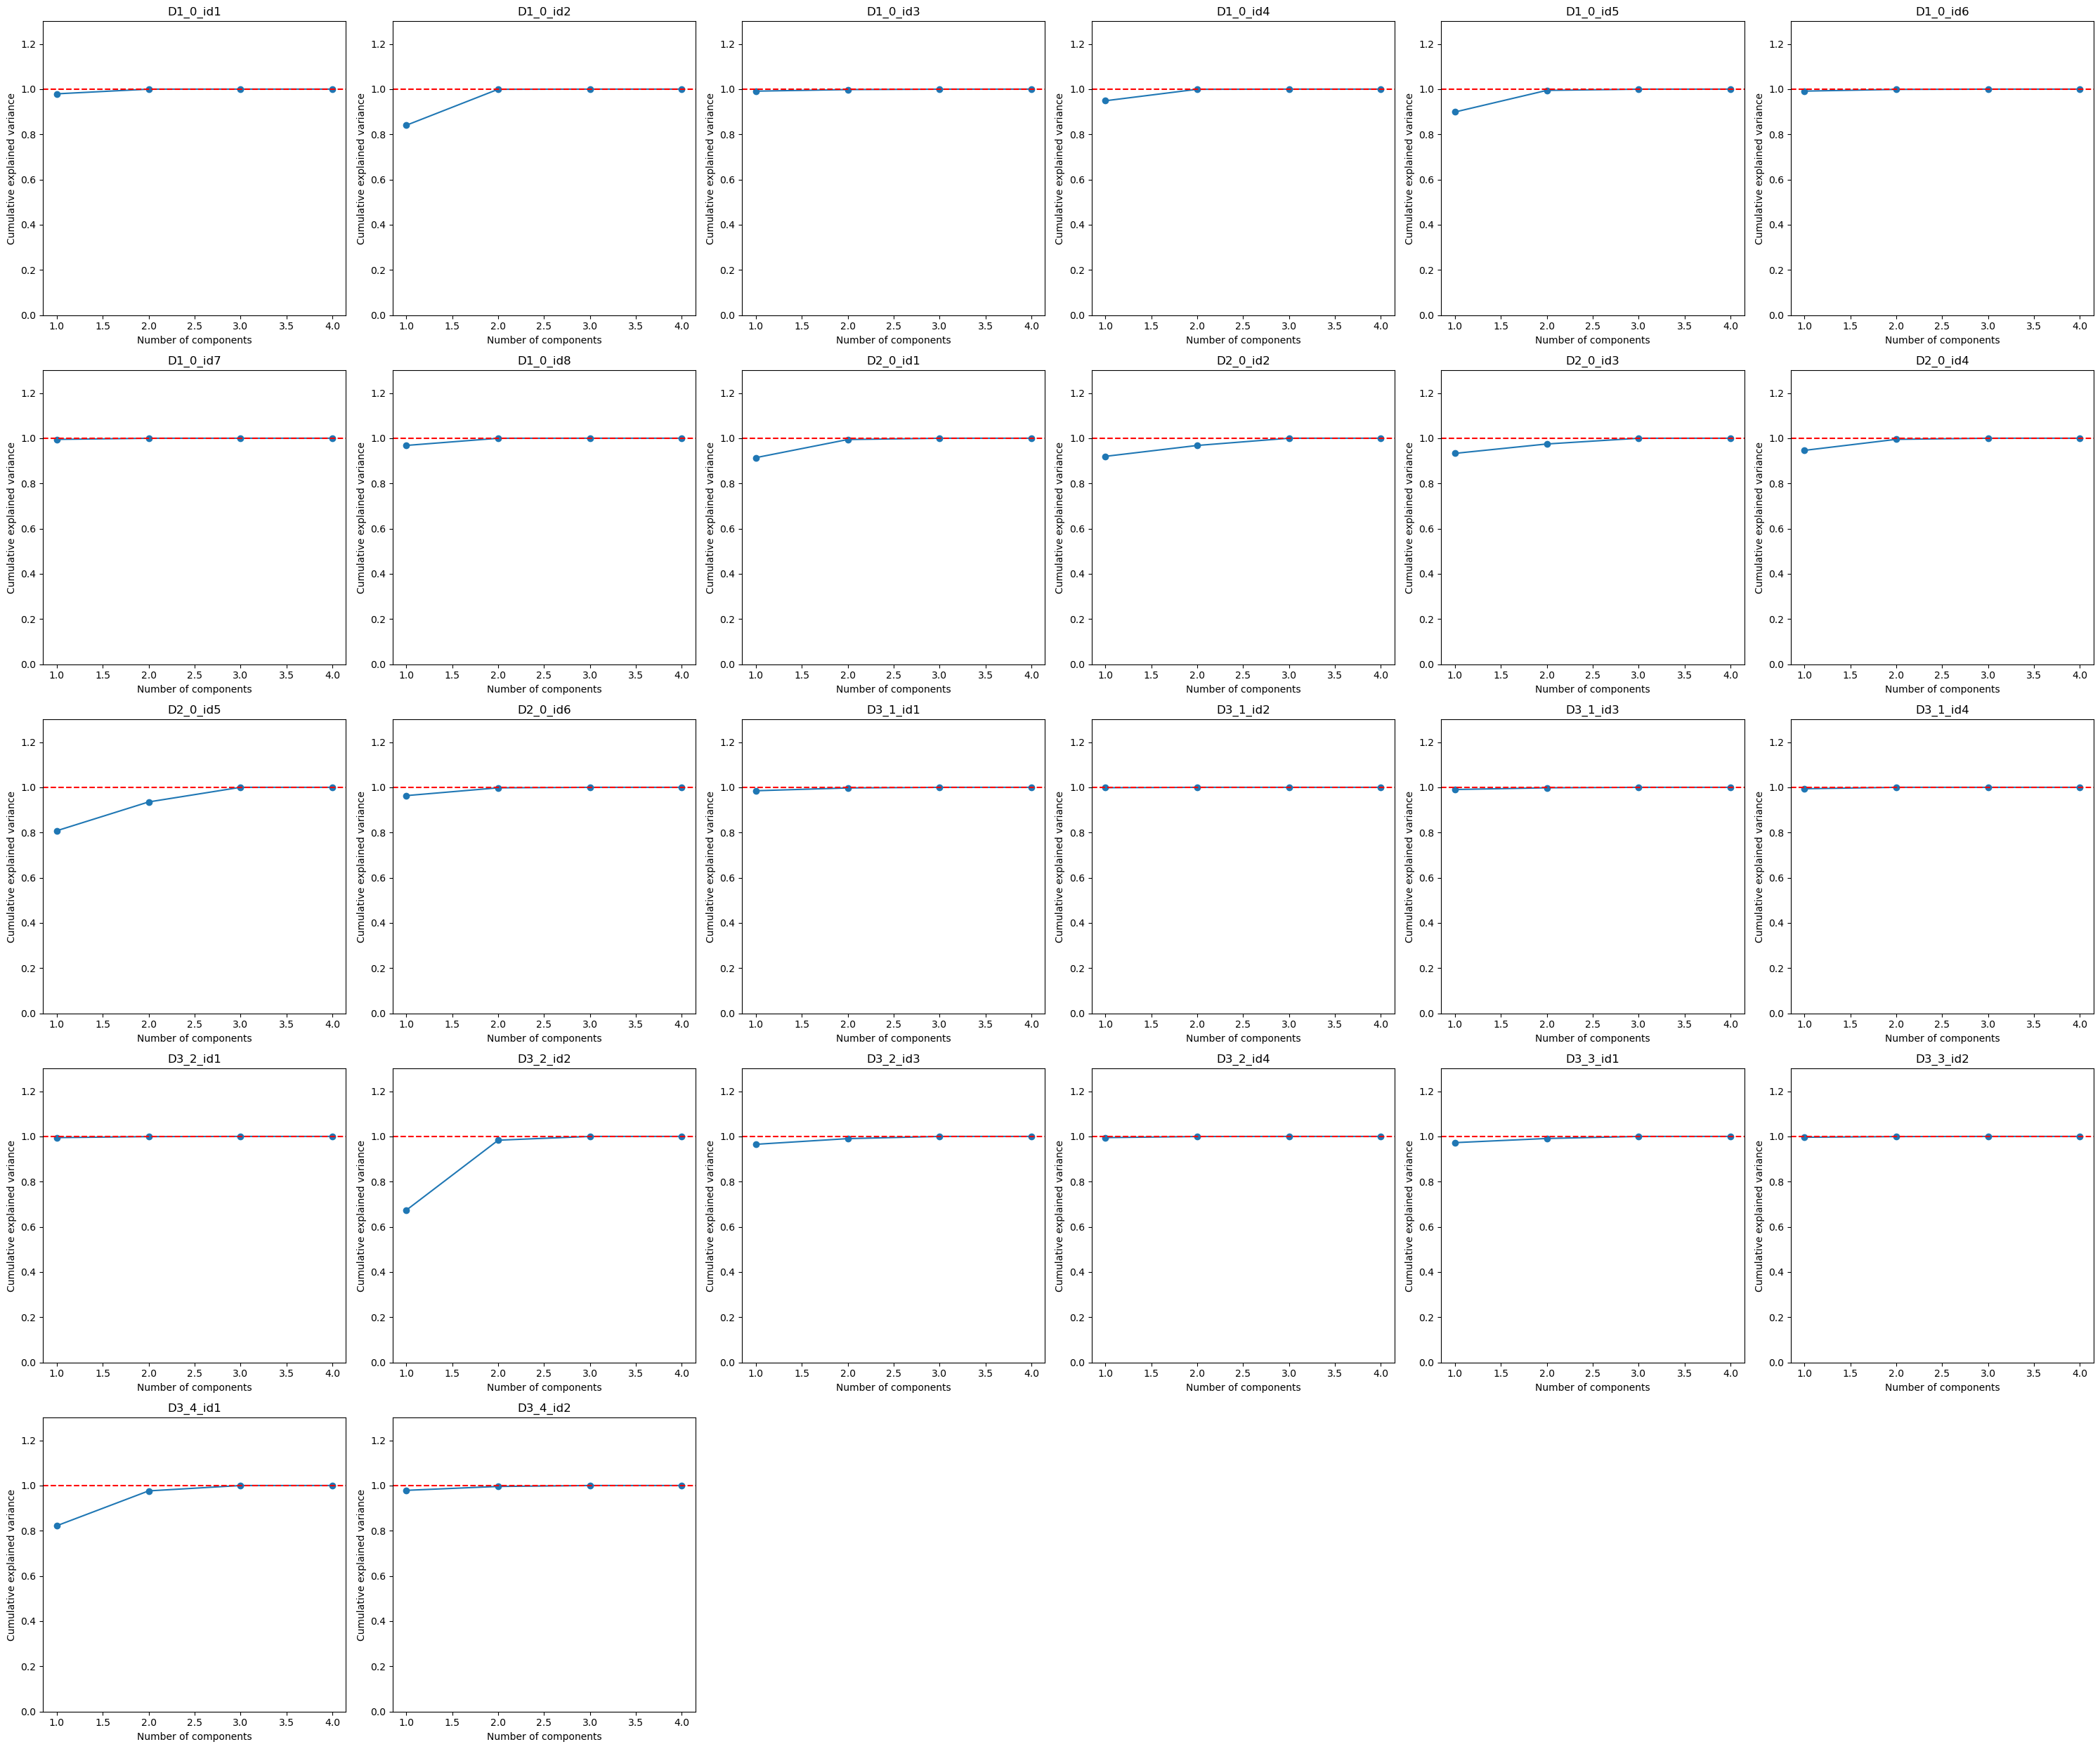

In [6]:
import matplotlib.pyplot as plt

# Set the number of subplots per row
subplots_per_row = 6

# Calculate the total number of rows needed
num_participants = len(participant_id)
num_rows = (num_participants - 1) // subplots_per_row + 1

# Create a new figure and axis objects
fig, axs = plt.subplots(num_rows, subplots_per_row, figsize=(30, 5 * num_rows))

# Flatten the axs array so that we can index it with a single number
axs = axs.flatten()

# Loop through participant names
for i, participant in enumerate(participant_id):
    
    # Extract the eigenvalues for the current participant
    Eval = pca_results[participant]['Eval']
    
    # Compute the proportion of variance explained by each PC
    variance_explained = Eval / np.sum(Eval)
    
    # Compute the cumulative explained variance
    cum_variance_explained = np.cumsum(variance_explained)
    
    # Create a plot of the cumulative explained variance vs PC
    pc_numbers = np.arange(1, len(cum_variance_explained) + 1)
    axs[i].plot(pc_numbers, cum_variance_explained, 'o-')
    axs[i].set_xlabel('Number of components')
    axs[i].set_ylabel('Cumulative explained variance')
    axs[i].set_ylim([0, 1.3])
    axs[i].set_title(participant)
    
    axs[i].axhline(y=1, color='red', linestyle='--')
# Hide any unused subplots
for i in range(num_participants, num_rows * subplots_per_row):
    axs[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## PC1 vs PC2 for each participant

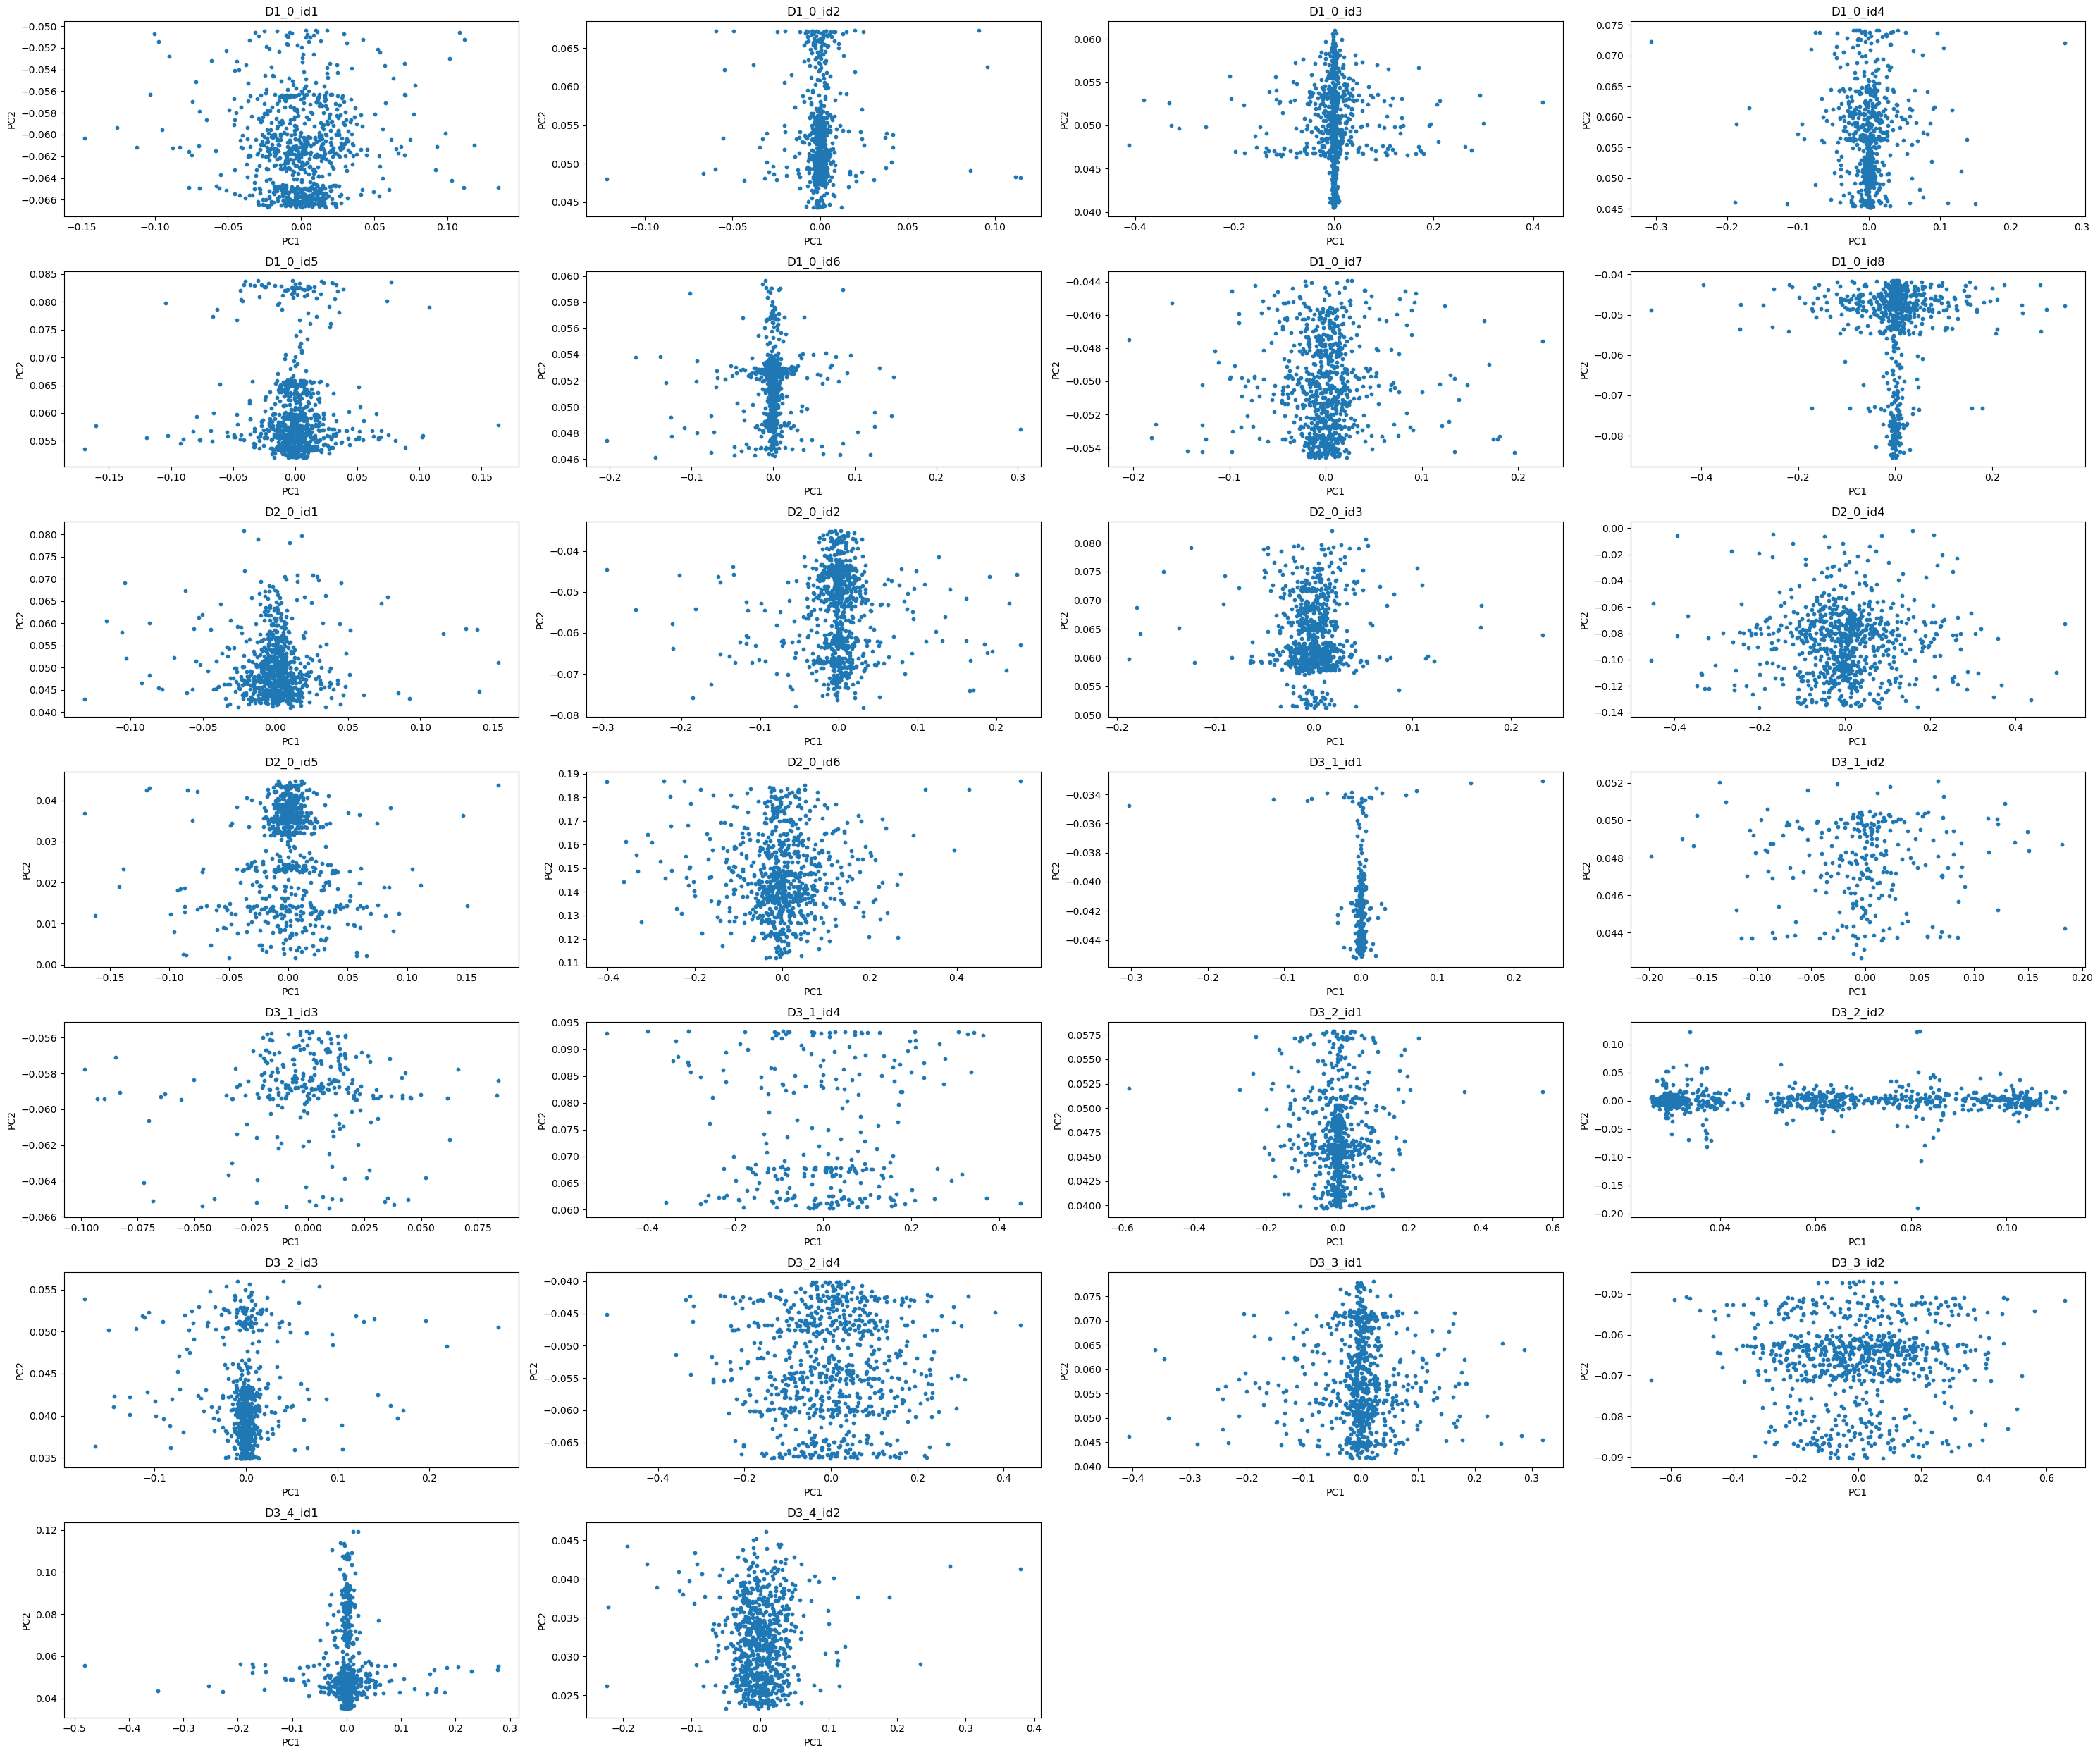

In [7]:
# Define the number of subplots per row and column
subplots_per_row = 4
subplots_per_col = int(np.ceil(len(participant_id) / subplots_per_row))

# Create a figure and a grid of subplots with the given dimensions
fig, axs = plt.subplots(nrows=subplots_per_col, ncols=subplots_per_row, figsize=(30,5*num_rows))

# Loop through participant names and their corresponding subplots
for i, participant in enumerate(participant_id):
    pca = pca_results[participant]

    # Extract the first two principal components
    pc1 = pca['Z'][0]
    pc2 = pca['Z'][1]

    # Calculate the row and column indices for the current participant's subplot
    row = i // subplots_per_row
    col = i % subplots_per_row

    # Create a scatter plot of PC1 vs PC2 in the current subplot
    axs[row, col].scatter(pc1, pc2, s=10)

    # Add axis labels and a title to the current subplot
    axs[row, col].set_xlabel('PC1')
    axs[row, col].set_ylabel('PC2')
    axs[row, col].set_title(participant)

# Remove any empty subplots
for i in range(len(participant_id), subplots_per_row*subplots_per_col):
    row = i // subplots_per_row
    col = i % subplots_per_row
    fig.delaxes(axs[row, col])

# Adjust the spacing between subplots and show the plot
fig.tight_layout()
plt.show()


## PC1 (or PC2) vs Time for all the participants together

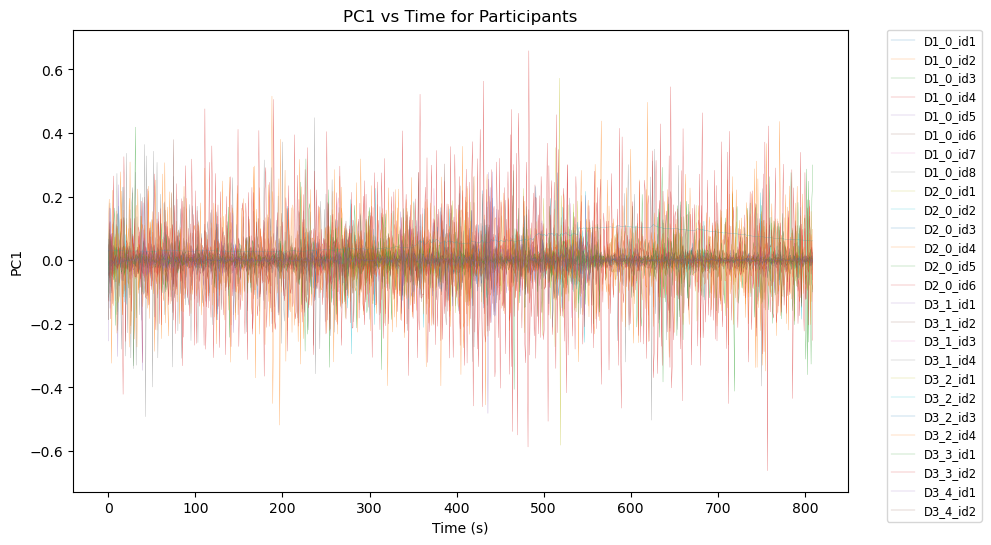

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Set the directory to save the plot
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Loop through participant names
for participant in participant_id:
    pca = pca_results[participant]
    pc1 = (pca["Z"][0])
    time = participant_data[participant]["Time"]
    
    # Plot PC1 vs Time for the current participant
    plt.plot(time, pc1, label=participant, linewidth=0.17)

# Add plot title and labels
plt.title("PC1 vs Time for Participants")
plt.xlabel("Time (s)")
plt.ylabel("PC1")

# Move legend outside the graph and make it 15% smaller
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small', markerscale=0.65)

# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)

# Save the plot
plt.savefig(os.path.join(plot_dir, 'PC1_vs_Time.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Other exploratory plots

## PC1 vs PC2 for all data for all the participants labeled by phase

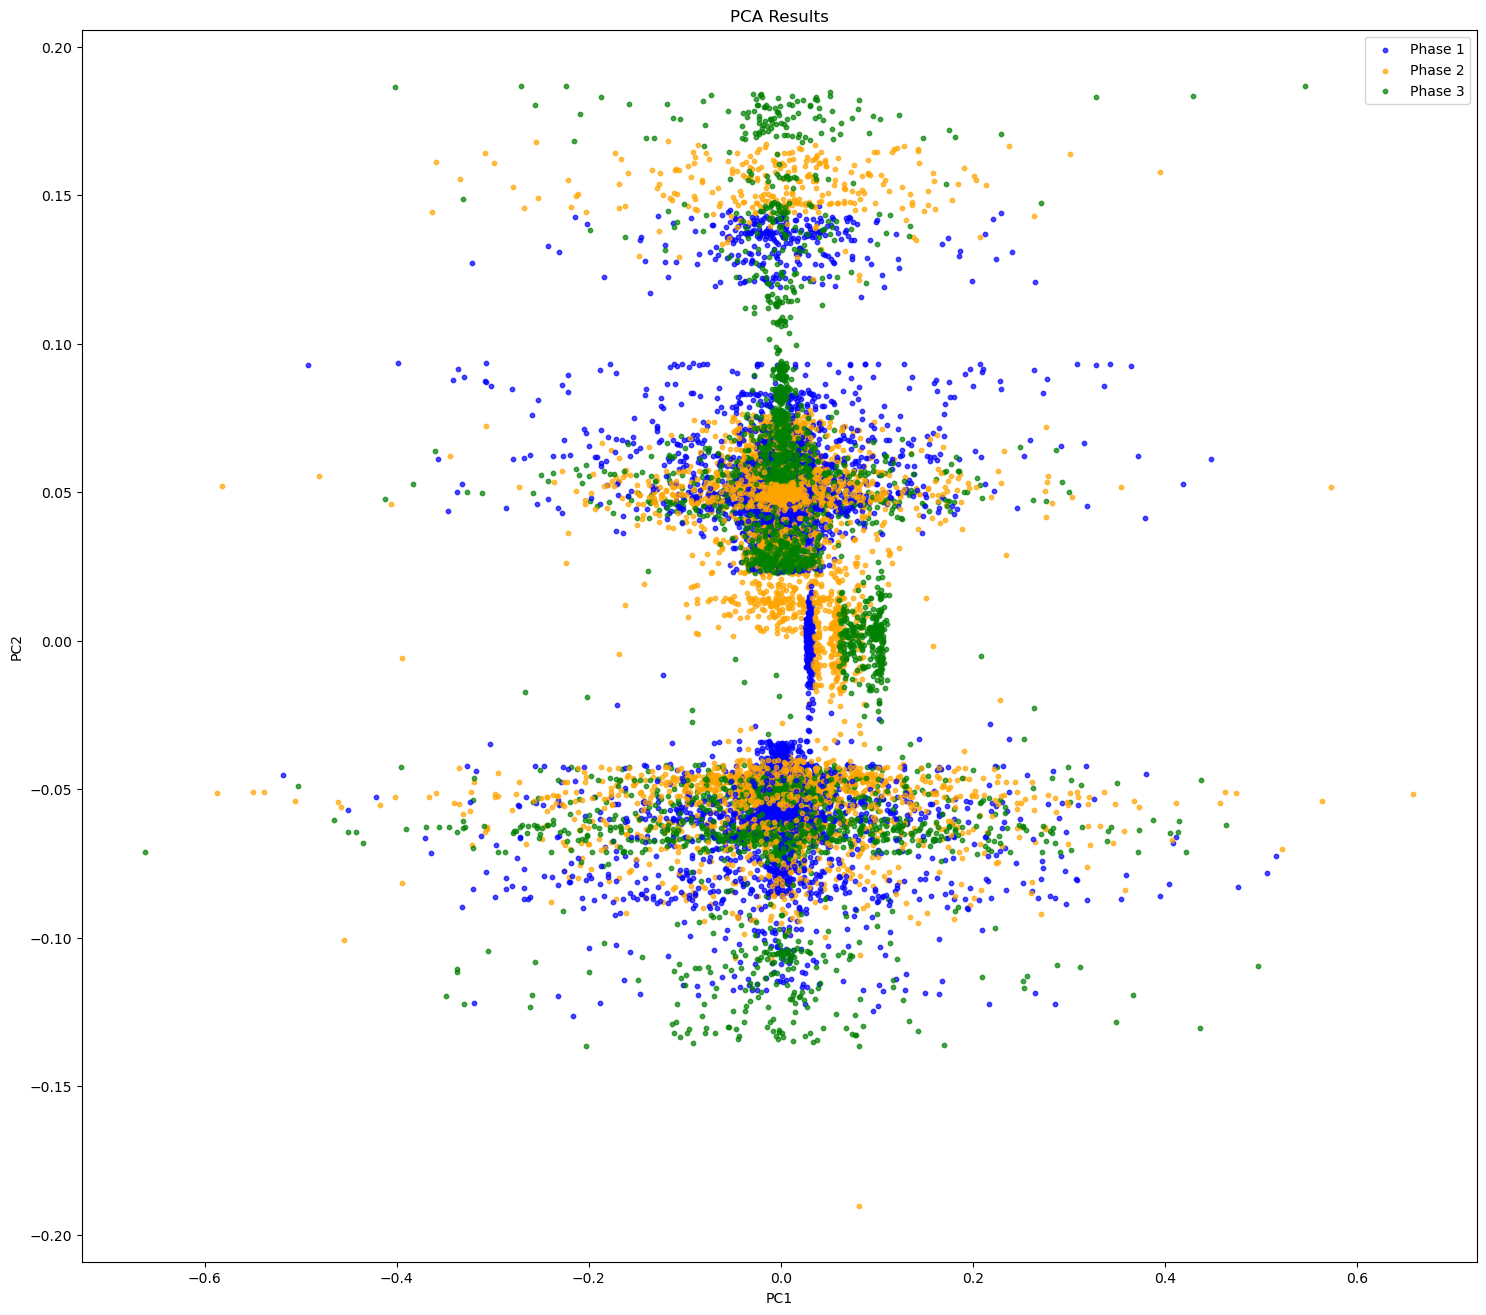

In [9]:
import matplotlib.pyplot as plt

# Define colors for each phase
phase_colors = {1: 'blue', 2: 'orange', 3: 'green'}

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(18, 16))

# Loop through participant names
for participant in participant_id:
    pca = pca_results[participant]

    # Extract the first two principal components
    pc1 = pca['Z'][0]
    pc2 = pca['Z'][1]

    # Plot the data points for each phase separately
    for phase in range(1, 4):
        phase_pc1 = pc1[(phase - 1) * 270:phase * 270]
        phase_pc2 = pc2[(phase - 1) * 270:phase * 270]
        ax.scatter(phase_pc1, phase_pc2, c=phase_colors[phase], label=f"Phase {phase}", alpha=0.7,  s=10)

# Add axis labels and a title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Results')

# Add the legend outside the loop
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:3], labels=labels[0:3], loc='upper right')

# Display the plot
plt.show()


## Correation matrix of biosignal measurements - HEATMAP

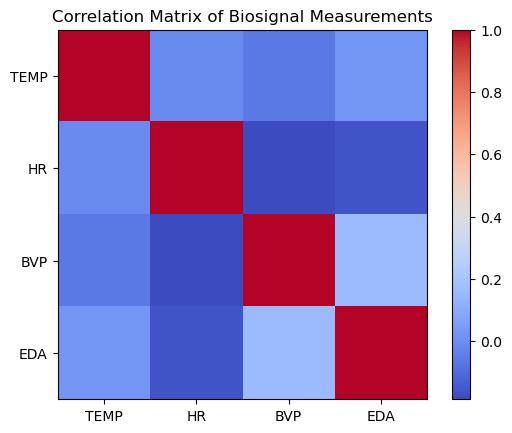

In [10]:
import numpy as np

# concatenate the Z matrix for all participants
Z_all = np.concatenate([pca_results[participant]['Z'] for participant in pca_results])

# calculate the correlation matrix
corr_matrix = np.corrcoef(Z_all, rowvar=False)

# visualize the correlation matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap='coolwarm')

# Add axis labels
feature_names = ["TEMP", "HR", "BVP", "EDA"]
ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

plt.colorbar(im)
plt.title('Correlation Matrix of Biosignal Measurements')
plt.show()


## PC1 vs Time for all participants (puzzler/not a puzzler)

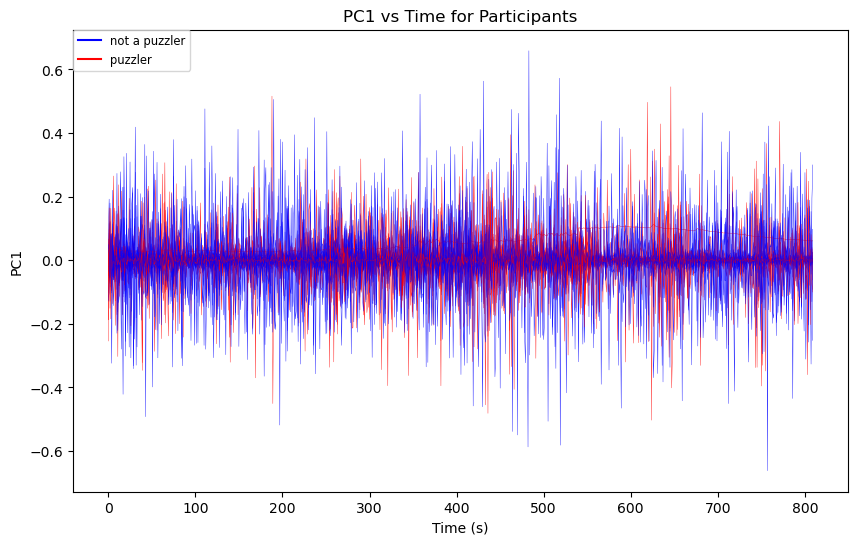

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

resp_df = datas["puzzler"]
norm_signals["puzzler"] = resp_df

# Set the directory to save the plot
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Loop through participant names
for participant in participant_id:
    pca = pca_results[participant]
    pc1 = (pca["Z"][0])
    time = participant_data[participant]["Time"]
    puzzler = norm_signals.loc[norm_signals["participant"]==participant, "puzzler"].iloc[0] # get the puzzler value for the current participant
    
    # Plot PC1 vs Time for the current participant, colored by puzzler feature
    if puzzler==0:
        plt.plot(time, pc1, color='blue', linewidth=0.27)
    else:
        plt.plot(time, pc1, color='red', linewidth=0.27)

# Add plot title and labels
plt.title("PC1 vs Time for Participants")
plt.xlabel("Time (s)")
plt.ylabel("PC1")

# Update the legend to show the colors for puzzlers and non-puzzlers
plt.legend(handles=[plt.Line2D([], [], color='blue', label='not a puzzler'), 
                    plt.Line2D([], [], color='red', label='puzzler')],
           loc='upper left', borderaxespad=0., fontsize='small', markerscale=0.65)

# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)

# Save the plot
plt.savefig(os.path.join(plot_dir, 'round__puzzler_PC1_vs_Time.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
